### import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Add
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import albumentations as A
import sklearn
from sklearn.model_selection import train_test_split

### Stanford Dogs Dataset
[Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)  
`wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar`  
`tar -xvf images.tar`

In [2]:
!pwd

/workspace/computer-vision/contests/stanford_dogs


In [3]:
DATA_PATH = "./data"

In [4]:
label_list, path_list = [], []

for root, directories, files in os.walk(DATA_PATH):
    if len(directories) == 0:
        class_name = root[root.find("-") + 1:]
        for file in files:
            label_list.append(class_name)
            path_list.append(os.path.join(root, file))

data_df = pd.DataFrame({"path": path_list, "label": label_list, })
#pd.set_option("display.max_rows", None)
#pd.set_option('display.max_colwidth', None)
one_hot_labels = pd.get_dummies(data_df["label"])
data_df = pd.concat([data_df, one_hot_labels], axis=1)
data_df

,path,label,Afghan_hound,African_hunting_dog,Airedale,American_Staffordshire_terrier,Appenzeller,Australian_terrier,Bedlington_terrier,Bernese_mountain_dog,...,schipperke,silky_terrier,soft-coated_wheaten_terrier,standard_poodle,standard_schnauzer,toy_poodle,toy_terrier,vizsla,whippet,wire-haired_fox_terrier
0,./data/n02095889-Sealyham_terrier/n02095889_93...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,./data/n02095889-Sealyham_terrier/n02095889_48...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,./data/n02095889-Sealyham_terrier/n02095889_13...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,./data/n02095889-Sealyham_terrier/n02095889_64...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,./data/n02095889-Sealyham_terrier/n02095889_60...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20575,./data/n02113186-Cardigan/n02113186_11400.jpg,Cardigan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20576,./data/n02113186-Cardigan/n02113186_2617.jpg,Cardigan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20577,./data/n02113186-Cardigan/n02113186_8414.jpg,Cardigan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20578,./data/n02113186-Cardigan/n02113186_13256.jpg,Cardigan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data_df["label"].value_counts().to_dict()

{'Maltese_dog': 252,
 'Afghan_hound': 239,
 'Scottish_deerhound': 232,
 'Pomeranian': 219,
 'Samoyed': 218,
 'Irish_wolfhound': 218,
 'Bernese_mountain_dog': 218,
 'Shih-Tzu': 214,
 'Great_Pyrenees': 213,
 'Leonberg': 210,
 'basenji': 209,
 'Tibetan_terrier': 206,
 'Airedale': 202,
 'EntleBucher': 202,
 'Sealyham_terrier': 202,
 'pug': 200,
 'Saluki': 200,
 'Lakeland_terrier': 197,
 'cairn': 197,
 'chow': 196,
 'papillon': 196,
 'Norwegian_elkhound': 196,
 'Australian_terrier': 196,
 'Newfoundland': 195,
 'beagle': 195,
 'Siberian_husky': 192,
 'Blenheim_spaniel': 188,
 'Ibizan_hound': 188,
 'bloodhound': 187,
 'whippet': 187,
 'Lhasa': 186,
 'Norwich_terrier': 185,
 'Japanese_spaniel': 185,
 'miniature_pinscher': 184,
 'silky_terrier': 183,
 'Boston_bull': 182,
 'Bedlington_terrier': 182,
 'Italian_greyhound': 182,
 'Pembroke': 181,
 'Dandie_Dinmont': 180,
 'Kerry_blue_terrier': 179,
 'malamute': 178,
 'basset': 175,
 'Norfolk_terrier': 172,
 'Rhodesian_ridgeback': 172,
 'Border_terri

### image visualization

In [6]:
def show_images(path_list, nrows=5, ncols=5, title=None):
    fig, axs = plt.subplots(figsize=(20, 20), nrows=nrows, ncols=ncols)
    for i in range(nrows):
        for j in range(ncols):
            img = cv2.cvtColor(cv2.imread(path_list[50 + nrows * i + j]), cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(50, 50))
            axs[i, j].imshow(img)
            axs[i, j].set_title(title)

In [7]:
#show_images(data_df[data_df["label"] == "Maltese_dog"]["path"].tolist(), title="Maltese_dog")

In [8]:
#show_images(data_df[data_df["label"] == "Staffordshire_bullterrier"]["path"].tolist(), title="Staffordshire_bullterrier")

In [9]:
#path = "./data/n02113186-Cardigan/n02113186_11400.jpg"
#path = "./data/n02113186-Cardigan/n02113186_2617.jpg"
#path = "./data/n02113186-Cardigan/n02113186_8414.jpg"
#path = "./data/n02104029-kuvasz/n02104029_4581.jpg"
#path = "./data/n02087046-toy_terrier/n02087046_4350.jpg"
path = "./data/n02088466-bloodhound/n02088466_3333.jpg"

(304, 179, 3)

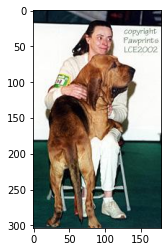

In [10]:
img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

In [11]:
def pad_to_square(img):
    h, w, c = img.shape
    if h == w:
        return img
    if h < w:
        pad1, pad2 = (w - h + 1) // 2, (w - h) // 2
        return cv2.copyMakeBorder(img, pad1, pad2, 0, 0, cv2.BORDER_WRAP)
    pad1, pad2 = (h - w + 1) // 2, (h - w) // 2
    return cv2.copyMakeBorder(img, 0, 0, pad1, pad2, cv2.BORDER_WRAP)

In [12]:
# def pad_border_wrap(img):
#     h, w, c = img.shape
#     return cv2.copyMakeBorder(img, h, h, w, w, cv2.BORDER_WRAP)

In [13]:
aug1 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, border_mode=cv2.BORDER_WRAP, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5)
])

In [14]:
def final_aug(image):
    
    h, w, c = image.shape
    max_size = max(h, w)
    pad_img = pad_to_square(image)
    aug1_img = aug1(image=pad_img)["image"]
    cc_img = A.CenterCrop(height=max_size, width=max_size, always_apply=True)(image=aug1_img)["image"]
    
    return cc_img

(304, 304, 3)

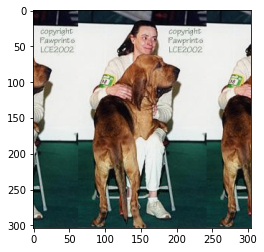

In [15]:
img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
final_aug_img = final_aug(img)
plt.imshow(final_aug_img)
final_aug_img.shape

In [16]:
def test_aug(image):

    h, w, c = image.shape
    max_size = max(h, w)
    pad_img = pad_to_square(image)
    cc_img = A.CenterCrop(height=max_size, width=max_size, always_apply=True)(image=pad_img)["image"]
    
    return cc_img

(304, 304, 3)

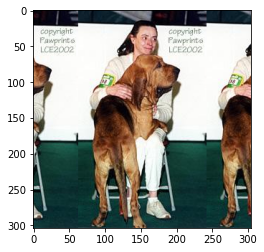

In [17]:
img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
test_aug_img = test_aug(img)
plt.imshow(test_aug_img)
test_aug_img.shape

### preprocess

In [18]:
def pre_zero_to_one(img):
    return (img / 255.).astype("float32")

In [19]:
def pre_m1_to_p1(img):
    return (img / 127.5 - 1).astype("float32")

### dataset by `tf.keras.utils.Sequence`

In [20]:
class Dog_Dataset(Sequence):
    
    def __init__(self, path_list, y_list, height, width, batch_size=64, augmentor=None, preprocess=None, shuffle=True):
        self.path_list = path_list
        self.y_list = y_list
        self.height = height
        self.width = width
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.preprocess = preprocess
        self.shuffle = shuffle
        if self.shuffle:
            self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.path_list) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_path = self.path_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x_list = []
        batch_y = None if self.y_list is None else self.y_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        for path in batch_path:
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            if self.augmentor:
                img = self.augmentor(image=img)
            img = cv2.resize(img, (self.width, self.height))
            if self.preprocess:
                img = self.preprocess(img)
            
            batch_x_list.append(img)
        
        batch_x = np.array(batch_x_list)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            idxs = np.arange(len(self.path_list))
            np.random.shuffle(idxs)
            self.path_list = self.path_list[idxs]
            self.y_list = self.y_list[idxs]

### train valid split

In [21]:
data_df

,path,label,Afghan_hound,African_hunting_dog,Airedale,American_Staffordshire_terrier,Appenzeller,Australian_terrier,Bedlington_terrier,Bernese_mountain_dog,...,schipperke,silky_terrier,soft-coated_wheaten_terrier,standard_poodle,standard_schnauzer,toy_poodle,toy_terrier,vizsla,whippet,wire-haired_fox_terrier
0,./data/n02095889-Sealyham_terrier/n02095889_93...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,./data/n02095889-Sealyham_terrier/n02095889_48...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,./data/n02095889-Sealyham_terrier/n02095889_13...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,./data/n02095889-Sealyham_terrier/n02095889_64...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,./data/n02095889-Sealyham_terrier/n02095889_60...,Sealyham_terrier,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20575,./data/n02113186-Cardigan/n02113186_11400.jpg,Cardigan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20576,./data/n02113186-Cardigan/n02113186_2617.jpg,Cardigan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20577,./data/n02113186-Cardigan/n02113186_8414.jpg,Cardigan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20578,./data/n02113186-Cardigan/n02113186_13256.jpg,Cardigan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=2023, stratify=data_df["label"])

In [23]:
train_df.shape, valid_df.shape

((16464, 122), (4116, 122))

In [24]:
def get_train_valid_dataset(data_df, image_size=(224, 224), batch_size=64):
    train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=2023, stratify=data_df["label"])
    train_path, train_label = train_df["path"].values, train_df.iloc[:, 2:].values
    valid_path, valid_label = valid_df["path"].values, valid_df.iloc[:, 2:].values
    height, width = image_size
    batch_size = batch_size
    
    train_ds = Dog_Dataset(
        path_list=train_path, y_list=train_label,
        height=height, width=width,
        batch_size=batch_size,
        augmentor=final_aug,
        preprocess=pre_m1_to_p1,
        shuffle=True
    )
    
    valid_ds = Dog_Dataset(
        path_list=valid_path, y_list=valid_label,
        height=height, width=width,
        batch_size=batch_size,
        augmentor=test_aug,
        preprocess=pre_m1_to_p1,
        shuffle=False
    )
    
    return train_ds, valid_ds

In [25]:
train_ds, valid_ds = get_train_valid_dataset(data_df, batch_size=64)

tr_image_batch, tr_label_batch = next(iter(train_ds))
val_image_batch, val_label_batch = next(iter(valid_ds))
print(tr_image_batch.shape, tr_image_batch.dtype, tr_label_batch.shape, tr_label_batch.dtype)
print(tr_image_batch[0], val_image_batch[0])
print(tr_label_batch, val_label_batch)

(64, 224, 224, 3) float32 (64, 120) uint8
[[[-0.56078434 -0.4117647  -0.827451  ]
  [-0.6313726  -0.45882353 -0.88235295]
  [-0.5294118  -0.3254902  -0.7490196 ]
  ...
  [-0.28627452 -0.15294118 -0.52156866]
  [-0.4745098  -0.35686275 -0.654902  ]
  [-0.44313726 -0.31764707 -0.6       ]]

 [[-0.5921569  -0.42745098 -0.827451  ]
  [-0.4117647  -0.22352941 -0.6313726 ]
  [-0.56078434 -0.34901962 -0.78039217]
  ...
  [-0.05882353 -0.02745098 -0.2784314 ]
  [-0.29411766 -0.21568628 -0.49019608]
  [-0.56078434 -0.4745098  -0.7490196 ]]

 [[-0.23921569 -0.05882353 -0.46666667]
  [-0.56078434 -0.37254903 -0.78039217]
  [-0.64705884 -0.43529412 -0.85882354]
  ...
  [ 0.5058824   0.46666667  0.30980393]
  [ 0.07450981  0.16862746 -0.16862746]
  [-0.25490198 -0.10588235 -0.49803922]]

 ...

 [[-0.37254903 -0.16078432 -0.5529412 ]
  [-0.39607844 -0.19215687 -0.58431375]
  [-0.5372549  -0.3254902  -0.7176471 ]
  ...
  [-0.33333334 -0.12941177 -0.6392157 ]
  [-0.3254902  -0.12156863 -0.6156863 ]
  

### time measurement

In [26]:
# import time

# train_ds, valid_ds = get_train_valid_dataset(data_df, batch_size=64)

# # Dataset을 64건씩 Fetch하면서 걸리는 시간 측정 
# start = time.time()
# for value1, value2 in iter(train_ds):
#     end = time.time()
#     print(end - start)
#     start = end

### model test

In [27]:
def create_model(model_type='efficientnetb0', in_shape=(224, 224, 3), n_classes=120):
    input_tensor = Input(shape=in_shape)

    if model_type == 'resnet50v2':
        base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'xception':
        base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb0':
        base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb1':
        base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb2':
        base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb3':
        base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb4':
        base_model = tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb5':
        base_model = tf.keras.applications.EfficientNetB5(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb6':
        base_model = tf.keras.applications.EfficientNetB6(include_top=False, weights='imagenet', input_tensor=input_tensor)
    elif model_type == 'efficientnetb7':
        base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=input_tensor)
        
    x = base_model.output  
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)    
    preds = Dense(units=n_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=preds)
    
    return model

In [28]:
def train_model(data_df, batch_size, model_type="xception"):
    train_ds, valid_ds = get_train_valid_dataset(data_df, batch_size=64)
    
    model = create_model(model_type)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
    
    history = model.fit(train_ds, epochs=10, validation_data=valid_ds, callbacks=([rlr_cb, ely_cb]), verbose=1)
    
    return model, history

In [29]:
xception_model, xception_history = train_model(data_df=data_df, batch_size=64, model_type='xception')

2023-05-13 07:20:14.912093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 07:20:14.926731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 07:20:14.954549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-13 07:20:14.957186: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/10


2023-05-13 07:20:24.688538: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2023-05-13 07:20:25.368416: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


258/258 [==============================] - 355s 1s/step - loss: 2.3275 - accuracy: 0.4925 - val_loss: 0.8427 - val_accuracy: 0.7726 - lr: 1.0000e-04
Epoch 2/10
258/258 [==============================] - 334s 1s/step - loss: 0.8035 - accuracy: 0.7702 - val_loss: 0.7394 - val_accuracy: 0.7835 - lr: 1.0000e-04
Epoch 3/10
258/258 [==============================] - 332s 1s/step - loss: 0.5100 - accuracy: 0.8466 - val_loss: 0.7075 - val_accuracy: 0.7945 - lr: 1.0000e-04
Epoch 4/10
258/258 [==============================] - 333s 1s/step - loss: 0.3571 - accuracy: 0.8926 - val_loss: 0.7017 - val_accuracy: 0.8015 - lr: 1.0000e-04
Epoch 5/10
258/258 [==============================] - 332s 1s/step - loss: 0.2483 - accuracy: 0.9238 - val_loss: 0.7351 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 6/10
258/258 [==============================] - 333s 1s/step - loss: 0.1928 - accuracy: 0.9397 - val_loss: 0.7651 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 7/10
258/258 [==============================]